## Overall request process

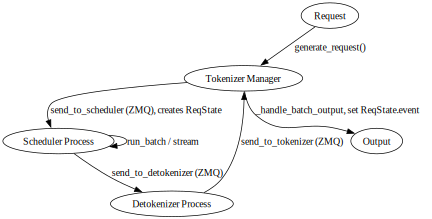

In [60]:
from graphviz import Digraph
dot = Digraph(engine='dot')
dot.attr(rankdir='TD', size='6, 5')
dot.node('R', 'Request')
dot.node('T', 'Tokenizer Manager')
dot.node('S', 'Scheduler Process')
dot.node('D', 'Detokenizer Process')
dot.node('O', 'Output')
dot.node('_', style='invis')
dot.edge('R', '_', style='invis')
dot.edge('O', '_', style='invis')
dot.edge('R', 'T', label='generate_request()')
dot.edge('T', 'S', label='send_to_scheduler (ZMQ), creates ReqState')
dot.edge('S', 'S', label='run_batch / stream')
dot.edge('S', 'D', label='send_to_detokenizer (ZMQ)')
dot.edge('D', 'T', label='send_to_tokenizer (ZMQ)')
dot.edge('T', 'O', label='_handle_batch_output, set ReqState.event')
dot

Upon receiving any new request, either the [SGL.Engine](https://github.com/sgl-project/sglang/blob/v0.5.2/python/sglang/srt/entrypoints/engine.py#L141-L292) entrypoint or the [launched server](https://github.com/sgl-project/sglang/blob/v0.5.2/python/sglang/srt/entrypoints/http_server.py#L464-L499) entrypoint will call `scheduler.tokenizer_manager.generate_request`.

The server entrypoint is just an HTTP server wrapper that calls [_launch_subprocesses](https://github.com/sgl-project/sglang/blob/v0.5.2/python/sglang/srt/entrypoints/engine.py#L725-L872), same as what SGL.Engine does.
So they will similarly "launch" two processes and a manager to host the background workers:
1. [run_scheduler_process](https://github.com/sgl-project/sglang/blob/v0.5.2/python/sglang/srt/entrypoints/engine.py#L775-L788) (using `mp.Process`):
    1. [Scheduler](https://github.com/sgl-project/sglang/blob/v0.5.2/python/sglang/srt/managers/scheduler.py#L2587)
    2. [main event loop](https://github.com/sgl-project/sglang/blob/v0.5.2/python/sglang/srt/managers/scheduler.py#L2612), it loops through:
        1. [Receive the request](https://github.com/sgl-project/sglang/blob/v0.5.2/python/sglang/srt/managers/scheduler.py#L811)
           * from either (non-blocking) [tokenizer or rpc](https://github.com/sgl-project/sglang/blob/v0.5.2/python/sglang/srt/managers/scheduler.py#L1018-L1025) zmq channels, depending on whether the caller is using SDK.
        3. [Schedule and process the next batch](https://github.com/sgl-project/sglang/blob/v0.5.2/python/sglang/srt/managers/scheduler.py#L814-L818)
            * calling the [run_batch](https://github.com/sgl-project/sglang/blob/v0.5.2/python/sglang/srt/managers/scheduler.py#L1798) function.
        5. [Take the batch `result`](https://github.com/sgl-project/sglang/blob/v0.5.2/python/sglang/srt/managers/scheduler.py#L819)
            1. Depending on [decode/extend/prefill](https://github.com/sgl-project/sglang/blob/v0.5.2/python/sglang/srt/managers/scheduler.py#L1881-L1884) decoding types, [stream out the results](https://github.com/sgl-project/sglang/blob/main/python/sglang/srt/managers/scheduler_output_processor_mixin.py#L303).
            2. For finished request IDs, [relay results to detokenizer](https://github.com/sgl-project/sglang/blob/main/python/sglang/srt/managers/scheduler_output_processor_mixin.py#L716-L720) via zmq channel.
3. [run_detokenizer_process](https://github.com/sgl-project/sglang/blob/v0.5.2/python/sglang/srt/entrypoints/engine.py#L829-L835) (using `mp.Process`)
    * [DetokenizerManager](https://github.com/sgl-project/sglang/blob/v0.5.2/python/sglang/srt/managers/detokenizer_manager.py#L294-L298) init and event loop.
       * Dispatch through [_request_dispatcher](https://github.com/sgl-project/sglang/blob/v0.5.2/python/sglang/srt/managers/detokenizer_manager.py#L102-L120): `recv_from_scheduler` and then `send_to_tokenizer`.
5. [_init_tokenizer_manager](https://github.com/sgl-project/sglang/blob/v0.5.2/python/sglang/srt/entrypoints/engine.py#L844-L846)
    * [TokenizerManager](https://github.com/sgl-project/sglang/blob/v0.5.2/python/sglang/srt/managers/tokenizer_manager.py#L137)
        * [generate_request](https://github.com/sgl-project/sglang/blob/v0.5.2/python/sglang/srt/managers/tokenizer_manager.py#L330) (main callee by entrypoints)
            * [auto_create_handle_loop](https://github.com/sgl-project/sglang/blob/v0.5.2/python/sglang/srt/managers/tokenizer_manager.py#L1026)
                * [handle_loop](https://github.com/sgl-project/sglang/blob/v0.5.2/python/sglang/srt/managers/tokenizer_manager.py#L1177) routes requests to, e.g., [_handle_batch_output](https://github.com/sgl-project/sglang/blob/v0.5.2/python/sglang/srt/managers/tokenizer_manager.py#L1184) (via `_result_dispatcher`) which eventually calls `state = rid_to_state.get(rid)`, `state.event.set()` and log metrics.
            * Do tokenization and [_send_one_request](https://github.com/sgl-project/sglang/blob/v0.5.2/python/sglang/srt/managers/tokenizer_manager.py#L619) (`self.send_to_scheduler.send_pyobj(tokenized_obj)`) then `_wait_one_response`. Or,
            * call [_handle_batch_request](https://github.com/sgl-project/sglang/blob/v0.5.2/python/sglang/srt/managers/tokenizer_manager.py#L739)
                * Under sequential tokenization and processing, similar to above, invoke [the tokenization steps](https://github.com/sgl-project/sglang/blob/v0.5.2/python/sglang/srt/managers/tokenizer_manager.py#L775-L784) for each instance of the batch.
            * The `_send_one_request` will create asynico event and assign `rid_to_state[obj.rid] = ReqState(.event=asyncio.Event())`

The TokenizerManager request origin:
```py
async def generate_request(
        self,
        obj: Union[GenerateReqInput, EmbeddingReqInput],
        request: Optional[fastapi.Request] = None,
    ):
        self.auto_create_handle_loop()
        ...
        if self.server_args.enable_lora and obj.lora_path:
                # Look up the LoRA ID from the registry and start tracking ongoing LoRA requests.
                obj.lora_id = await self.lora_registry.acquire(obj.lora_path)

            if obj.is_single:
                tokenized_obj = await self._tokenize_one_request(obj)
                state = self._send_one_request(obj, tokenized_obj, created_time)
                async for response in self._wait_one_response(obj, state, request):
                    yield response
            else:
                async for response in self._handle_batch_request(
                    obj, request, created_time
                ):
                    yield response
        
def _send_one_request(
        self,
        obj: Union[GenerateReqInput, EmbeddingReqInput],
        tokenized_obj: Union[TokenizedGenerateReqInput, TokenizedEmbeddingReqInput],
        created_time: Optional[float] = None,
    ):
        self.send_to_scheduler.send_pyobj(tokenized_obj)
        state = ReqState([], False, asyncio.Event(), obj, created_time=created_time)
        self.rid_to_state[obj.rid] = state
        return state
```